In [2]:
%load_ext autoreload
%autoreload 2

In [28]:
import random

import IPython.display as ipd
import matplotlib.pyplot as plt
import penn
import ppgs
import torch
import torchaudio

import promonet

In [4]:
# Input representation
ppgs.REPRESENTATION = 'mel'

# Local checkpoint to use
# If None, Huggingface will be used unless a checkpoint is given in the CLI
ppgs.LOCAL_CHECKPOINT = f'/repos/ppgs/runs/mel/00200000.pt'

### Load audio

In [75]:
stems = promonet.load.partition('vctk')['valid']
stem = random.choice(stems)
print(stem)
audio = promonet.load.audio(promonet.CACHE_DIR / 'vctk' / f'{stem}-100.wav')
# audio = promonet.load.audio('/hemera-storage1/pardo/max/test-audio/ill-be-back.wav')[:, :-int(.17 * promonet.SAMPLE_RATE)]
ipd.Audio(audio, rate=promonet.SAMPLE_RATE)

0016/000174


In [30]:
def pitch_track(audio, threshold=None, decoder='argmax'):
    return penn.from_audio(
        audio,
        sample_rate=promonet.SAMPLE_RATE,
        hopsize=promonet.convert.samples_to_seconds(promonet.HOPSIZE),
        fmin=promonet.FMIN,
        fmax=promonet.FMAX,
        batch_size=2048,
        center='half-hop',
        decoder=decoder,
        interp_unvoiced_at=threshold,
        gpu=0)

In [76]:
pitch, periodicity = pitch_track(audio, decoder='viterbi')

Linear (α = 0.080)
Linear (α = 0.160)
Linear (α = 0.320)


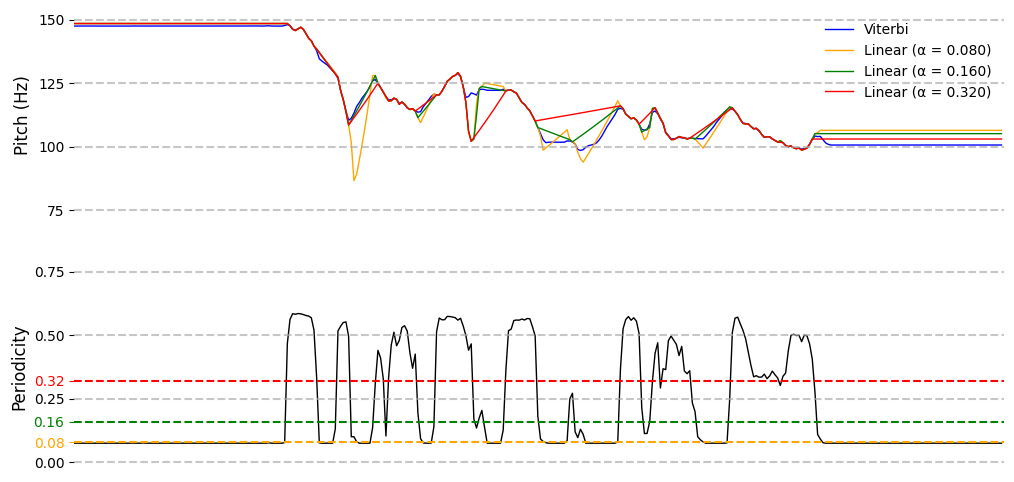

In [78]:
pitches = {'Viterbi': pitch.cpu().squeeze()}
thresholds = [.08, .16, .32]
for threshold in thresholds:
    key = 'Argmax' if threshold == 0 else f'Linear (α = {threshold:.03f})'
    print(key)
    pitches[key] = pitch_track(audio, threshold=threshold)[0].cpu().squeeze()

figure, axes = plt.subplots(2, 1, figsize=(12, 6))
colors = ['blue', 'orange', 'green', 'red']
for i, (k, p) in enumerate(pitches.items()):
    axes[0].plot(p.squeeze().cpu(), linewidth=1., label=k, color=colors[i])
axes[0].legend(frameon=False)
ymin = min(min(val) for val in pitches.values())
ymax = max(max(val) for val in pitches.values())
axes[0].set_xmargin(0.)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].set_xticks([])
ymin = ymin // 25 * 25
ymax = (ymax + 25) // 25 * 25
ystep = 25 if (ymax - ymin <= 150) else 50
yticks = torch.arange(ymin, ymax + ystep, ystep)
axes[0].set_yticks(yticks)
for tick in yticks:
    axes[0].hlines(tick, xmin=0., xmax=pitch.shape[-1], color='#aaaa', linestyle='--')
axes[0].set_ylabel('Pitch (Hz)', fontsize=12)

axes[1].plot(periodicity.squeeze().cpu(), color='black', linewidth=1.)
ymin = periodicity.min()
ymax = periodicity.max()
axes[1].set_xmargin(0.)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].set_xticks([])
ymin = ymin // .25 * .25
ymax = (ymax + .25) // .25 * .25
ystep = .25
yticks = set(torch.arange(ymin, ymax + ystep, ystep).tolist())
for threshold in thresholds:
    yticks.add(threshold)
yticks = list(yticks)
tickobjs = axes[1].set_yticks(yticks)
for i, threshold in enumerate(thresholds):
    idx = yticks.index(threshold)
    color = colors[i + 1]
    axes[1].get_yticklabels()[idx].set_color(color)
    tickobjs[idx]._apply_params(color=color)
    
for tick in yticks:
    if tick in thresholds:
        color = colors[thresholds.index(tick) + 1]
    else:
        color = '#aaaa'
    axes[1].hlines(tick, xmin=0., xmax=periodicity.shape[-1], color=color, linestyle='--')
axes[1].set_ylabel('Periodicity', fontsize=12)
plt.savefig(f'pitch-decode.png', bbox_inches='tight', pad_inches=0, transparent=True)